In [ ]:
!pip uninstall -y protobuf tensorflow
!pip install protobuf==3.20.3 tensorflow

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow.keras import layers, models, Sequential
from tensorflow.keras.utils import image_dataset_from_directory, load_img, img_to_array
import zipfile
import matplotlib.pyplot as plt
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"]="3"

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
#setting up important var for loading images later on
BATCH_SIZE=32
IMG_SIZE=(224,224)
SEED=42
EXTRACT_PATH="/kaggle/input/civic-issue-dataset/Dataset"
selected_class=["NoIssue","Issues"]

In [ ]:
#loading up images and dividing them for the neural net
train_data=tf.keras.utils.image_dataset_from_directory(
    EXTRACT_PATH,
    class_names=selected_class,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="binary" 
)

#validation dataset
validation_data=tf.keras.utils.image_dataset_from_directory(
    EXTRACT_PATH,
    class_names=selected_class,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="binary"
)
#now dividing the validation data set into 
total_number_of_batches_in_validation_data=validation_data.cardinality().numpy() #converts total number of batches in the set and converts the tensor into python integer with .numpy function here
no_of_batches_in_validation_data=total_number_of_batches_in_validation_data//2 #this is a floor division operator


#now from the set of batches of the image creating subset into the validation and the test subset
validation=validation_data.take(no_of_batches_in_validation_data)
test=validation_data.skip(no_of_batches_in_validation_data)

In [ ]:
print(f"Class names: {train_data.class_names}")
print("For values:\n")
for i, class_name in enumerate(train_data.class_names):
    print(f"{class_name}:{i}\n")

In [ ]:
#to augment data which we should do while training 
data_augmentation=tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.15),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
    tf.keras.layers.GaussianNoise(0.05),
    tf.keras.layers.RandomTranslation(0.1,0.1),
    tf.keras.layers.RandomCrop(224,224),
    tf.keras.layers.RandomBrightness(factor=0.2),
    tf.keras.layers.RandomSaturation(0.05),
    tf.keras.layers.RandomFlip("vertical"),
])

#setting var to send for training to send info about input
input=tf.keras.Input(shape=(224,224,3))


#now the acutal model which would be we want conv2d->pooling->conv2d->pooling->conv2d_>pooling-> flatten all the data two dense layer with relu
model=tf.keras.Sequential([
    input,
    data_augmentation,
    tf.keras.layers.Rescaling(1./255),

#CNN LAYERS
    tf.keras.layers.Conv2D(32,3,padding='same',activation="relu"),
    #here 32 is the number of filters/kernels, padding is same so it extends for the edges with 0 values and activation we chose is relu
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(64,3, padding="same",activation="relu"),
    tf.keras.layers.MaxPooling2D(),
    
    tf.keras.layers.Conv2D(128,3,padding="same",activation="relu"),
    tf.keras.layers.MaxPooling2D(),

    #now flatten this cube of input
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.5), #this makes the neural net to ignore 50 percent of the units all of the time so it would not look for same type of data everytime and prevent overfitting
    tf.keras.layers.Dense(1,activation="sigmoid")
])
#now compile and fit them
model.compile(optimizer="adam",
             loss=BinaryCrossentropy(from_logits=False),
             metrics=["accuracy",
             tf.keras.metrics.Precision(name="Precision"),
             tf.keras.metrics.Recall(name="recall"),])
history=model.fit(
    train_data,
    validation_data=validation,
    epochs=100,
    callbacks=[
        EarlyStopping(
            monitor="val_accuracy", #checks for val_accuracy
            patience=5,#wait tills 5 epochs
            restore_best_weights=True,#uses best weight
        ),
        ModelCheckpoint(
            "best_model.keras",#givesbest model according to val_accuracy
            monitor="val_accuracy",
            save_best_only=True,
            verbose=1 #prints only certain line of epoch for 1 and for 0 is silence and for 2 is every line
        )
    ]
)


test_loss,test_acc,test_precision,test_recall=model.evaluate(validation_data)
print(f"Accuracy: {test_acc:4f}, Precision:{test_precision:.4f}, Recall:{test_recall:.4f}")

For accuracy:
1) We have total of 15.6k  images of issues and 3954 images of non-issues and total of 19549 images.
2) For threshold accuracy we take a very dumb modal that would always predict the class with higher images so which would be:
       threshold_accuracy=(15640/19549)*100=80.004%
3) However, we do need to figure out recall and precision values which we take harmonic mean of must be >=0.65
   NOTE: Why do we take recall and precision here?
   => We do it because we have unbalanced data not only we need accurate value we need values with good precision and recall value where,<br>
   precision=(True positive values(values we predicted positive and is positive))/(No of True values we predict(both false and true positive))<br>
   recall=(true +ve(no of predicted=actual true)/Total actual positive value(both true positive we predict and false negative we predict))

In [ ]:
os.makedirs("/kaggle/working/models",exist_ok=True)
model.save("/kaggle/working/models/pothole_model.keras")

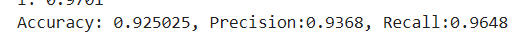

This is for cv data

In [ ]:
result=model.evaluate(test)
print(f"For the unseen test data of the entire training this model has accuracy of {result[1]:.4f}, precision of {result[2]:.4f}, and recall of {result[3]:.4f}")

Harmonic mean we got is 0.95855 which is a very good value for the data

In [ ]:
def predict_for_single_image(model, img_path):
    img=tf.keras.utils.load_img(img_path, target_size=(224,224))
    img_array=tf.keras.utils.img_to_array(img)
    img_array=np.expand_dims(img_array, axis=0)
    prediction=model.predict(img_array)
    probability=prediction[0][0]
    if probability>0.5:
        return 1;
    return 0;

In [ ]:
#to load up images
print(f"For i1 we got {predict_for_single_image(model, "/kaggle/input/helpppp/helppp/i1.png")}")
print(f"For i11 we got {predict_for_single_image(model, "/kaggle/input/helpppp/helppp/i11.jpeg")}")
print(f"For i2 we got {predict_for_single_image(model, "/kaggle/input/helpppp/helppp/i2.png")}")
print(f"For i3 we got {predict_for_single_image(model, "/kaggle/input/helpppp/helppp/i3.png")}")
print(f"For n1 we got {predict_for_single_image(model, "/kaggle/input/helpppp/helppp/n1.jpg")}")
print(f"For n2 we got {predict_for_single_image(model, "/kaggle/input/helpppp/helppp/n2.jpg")}")
print(f"For n3 we got {predict_for_single_image(model, "/kaggle/input/helpppp/helppp/n3.png")}")
print(f"For n4 we got {predict_for_single_image(model, "/kaggle/input/helpppp/helppp/n4.jpeg")}")


In [ ]:
import shutil

# Zip the folder for easy download
shutil.make_archive("/kaggle/working/models", 'zip', "/kaggle/working/models")

In [ ]:
#this is to see what our model did and how it is predicting
def visualisation(model,dataset,num_images=32):
    images, label=next(iter(dataset.take(1))) #take 1 takes one batch from tensorflow data set
    #where (image, 0 or 1) and this is returned as ptr or itr and next just gives access to it
    #following model is trained model as above
    pred=model.predict(images)
    plt.figure(figsize=(90,80))#image with 15 inches height and 10 inches width

    #randomly taking images
    indices=np.random.choice(range(len(images)),num_images,replace=False)
    #this randomly takes images from total number of images with replace=false so no duplicate images will be passes
    

    for i, idx in enumerate(indices):
        ax=plt.subplot(8,4,i+1) #creating subplot of 8*4 grid
        #converting images into the original scale as we rescale it into the image
        plt.imshow(images[idx].numpy().astype("uint8"))#displays image by converting first tensor into pixel values and then uint8 ie 0-255 
        actual_val=int(label[idx])
        predicted_val=1 if pred[idx]>0.5 else 0
        color ="green" if actual_val==predicted_val else "red"
        title=f"Actual:{actual_val}\nPredicted:{predicted_val}"
        plt.title(title,color=color,fontsize=40,fontweight="bold")
        plt.axis("off")

    #adding horizontal and vertical spaces between plots
    plt.subplots_adjust(hspace=0.6,wspace=0.3)
    plt.tight_layout
    plt.show()

In [ ]:
#seeing how model predicted for different images
visualisation(model,train_data)

In [ ]:
visualisation(model,validation)

In [ ]:
visualisation(model,test)